In [1]:
{
    "name": "Dev Container",
    "image": "mcr.microsoft.com/devcontainers/python:3.9",
    "features": {},
    "customizations": {
        "vscode": {
            "extensions": [
                "ms-python.python",
                "ms-python.vscode-pylance"
            ]
        }
    },
    "postCreateCommand": "pip install -r requirements.txt"
}

{'name': 'Dev Container',
 'image': 'mcr.microsoft.com/devcontainers/python:3.9',
 'features': {},
 'customizations': {'vscode': {'extensions': ['ms-python.python',
    'ms-python.vscode-pylance']}},
 'postCreateCommand': 'pip install -r requirements.txt'}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from mlxtend.frequent_patterns import fpgrowth 
import numpy as np

In [3]:
pip show mlxtend

/home/codespace/.python/current/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=24090) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Name: mlxtend
Version: 0.23.4
Summary: Machine Learning Library Extensions
Home-page: https://github.com/rasbt/mlxtend
Author: 
Author-email: Sebastian Raschka <mail@sebastianraschka.com>
License: BSD 3-Clause
Location: /home/codespace/.python/current/lib/python3.12/site-packages
Requires: joblib, matplotlib, numpy, pandas, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
file_path = "/workspaces/DM_MidProject/Online Retail 4.xlsx"

df = pd.read_excel(file_path)
print("Columns in the file:", df.columns)

df = pd.read_excel(file_path, usecols=['InvoiceNo', 'Description', 'Quantity'])

print(df.head())

Columns in the file: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
  InvoiceNo                          Description  Quantity
0    536365   WHITE HANGING HEART T-LIGHT HOLDER         6
1    536365                  WHITE METAL LANTERN         6
2    536365       CREAM CUPID HEARTS COAT HANGER         8
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE         6
4    536365       RED WOOLLY HOTTIE WHITE HEART.         6


In [ ]:
df.dropna(inplace=True)

# Removing canceled transactions
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [ ]:
# Convert InvoiceNo to string
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

# Create Transactional Format
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack(fill_value=0)
basket = (basket > 0).astype(int)  # Convert to binary matrix



In [ ]:
# Reduce dataset size by filtering out infrequent items
basket = basket.loc[:, basket.sum() > 5] 

In [ ]:

min_support = 0.02  
frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True)



/home/codespace/.python/current/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
min_confidence = 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)


In [10]:
top_rules = rules.sort_values(by="lift", ascending=False).head(5)
print("Top 5 Association Rules:\n", top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Top 5 Association Rules:
                                           antecedents  \
48                   (PINK REGENCY TEACUP AND SAUCER)   
45  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...   
46  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
47                  (GREEN REGENCY TEACUP AND SAUCER)   
41                   (PINK REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
48  (GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...  0.026298    0.707572   
45                   (PINK REGENCY TEACUP AND SAUCER)  0.026298    0.705729   
46                  (GREEN REGENCY TEACUP AND SAUCER)  0.026298    0.904841   
47  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...  0.026298    0.533990   
41                  (GREEN REGENCY TEACUP AND SAUCER)  0.030713    0.826371   

         lift  
48  18.988353  
45  18.988353  
46  18.373184  
47  18.373184  
41  16.779804  


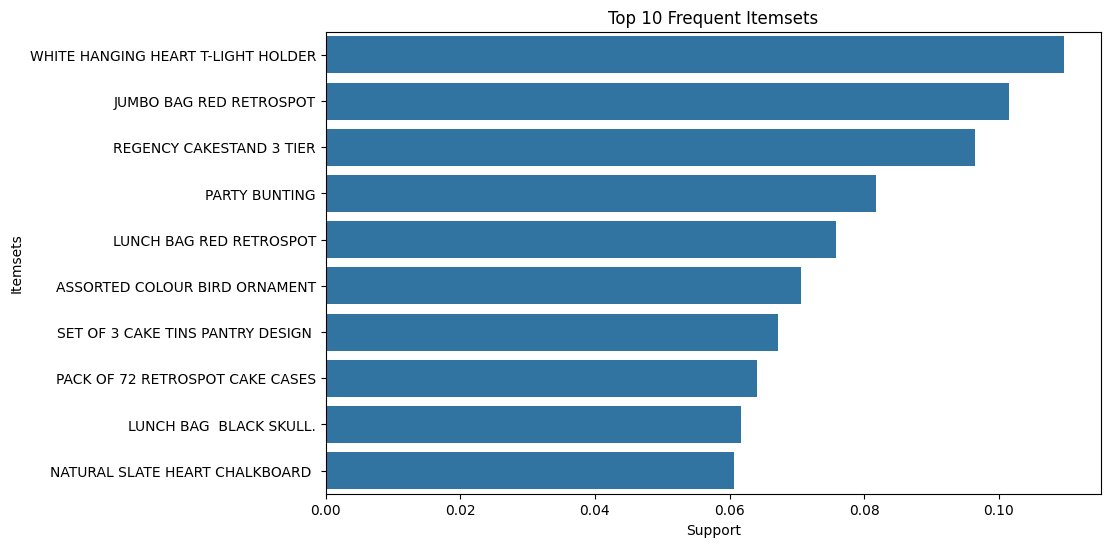

In [ ]:
plt.figure(figsize=(10, 6))

top_10_frequent = frequent_itemsets.sort_values(by=['support'], ascending=False).head(10)
sns.barplot(x=top_10_frequent['support'],
            y=top_10_frequent['itemsets'].apply(lambda x: ', '.join(list(x))).astype(str))
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.title("Top 10 Frequent Itemsets")
plt.show()

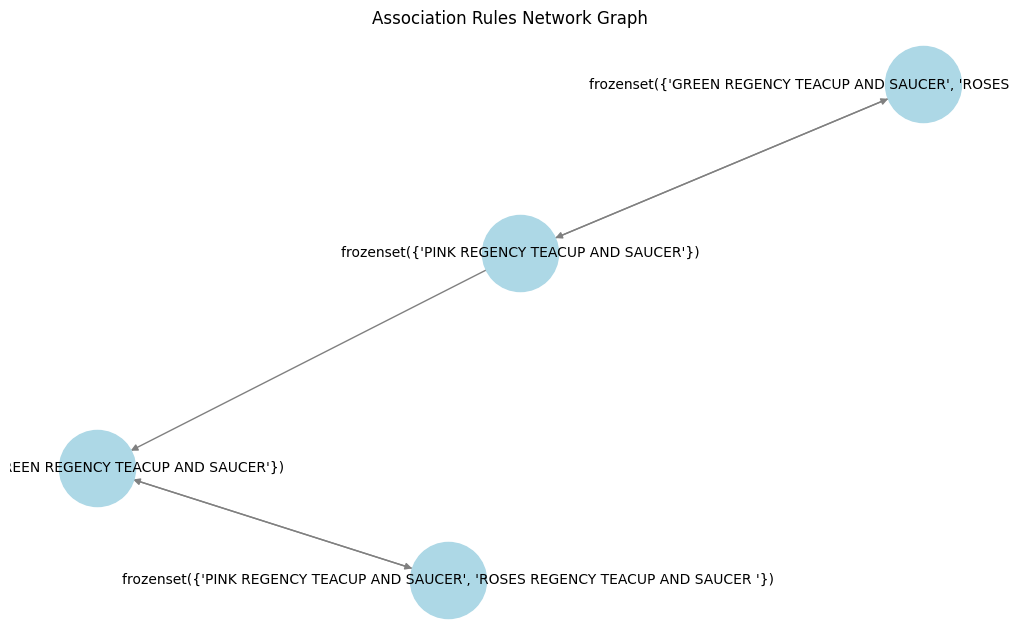

In [12]:
G = nx.DiGraph()
for _, row in top_rules.iterrows():
    G.add_edge(str(row['antecedents']), str(row['consequents']), weight=row['lift'])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
plt.title("Association Rules Network Graph")
plt.show()

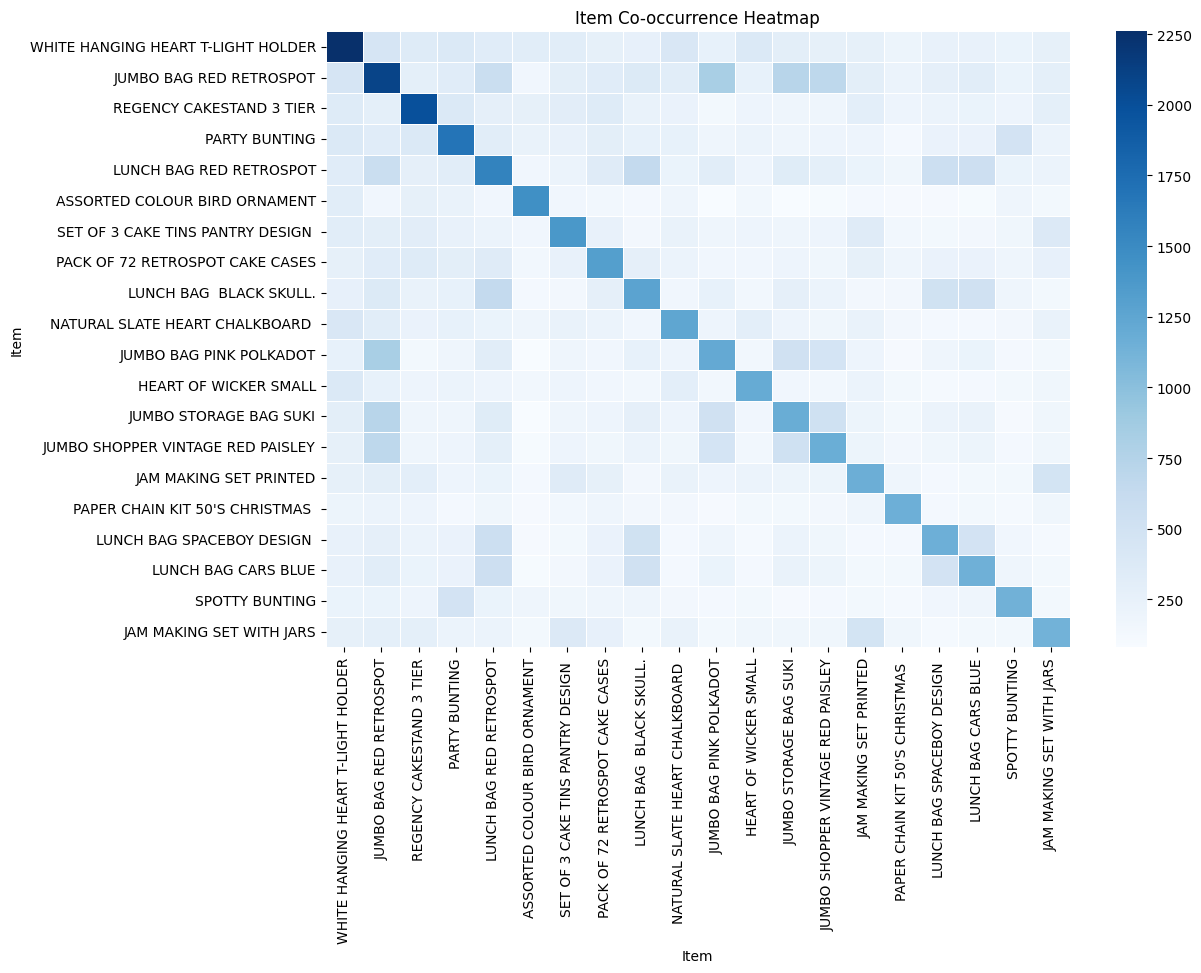

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
top_items = basket.sum().nlargest(20).index  
basket = basket[top_items]


co_occurrence_matrix = np.dot(basket.T, basket)  


co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=basket.columns, columns=basket.columns)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(co_occurrence_df, cmap="Blues", annot=False, fmt=".0f", linewidths=0.5)
plt.title("Item Co-occurrence Heatmap")
plt.xlabel("Item")
plt.ylabel("Item")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()